# LSTM Network - Stock Price Prediction

A stacked LSTM (Long Short-Term Memory) model built using data from a course on Udemy called [Deep Learning A-Z](https://www.udemy.com/course/deeplearning/learn/lecture/8374794). The dataset consists of Google's daily stock price over 5 years from 03/01/2012 to 31/12/2016. The model attempts to predict a daily price for the stock, given 60 days of prior stock prices.

<br></br>
***
## Libraries

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

<br></br>
***
## Data Preprocessing

In [30]:
trainingDataCSV = pd.read_csv('Google_Stock_Price_Train.csv')

# Convert csv to a numpy array using all rows and column 1 (i.e: Opening price)
trainingSet = trainingDataCSV.iloc[:, 1:2].values

# Normalisation
sc = MinMaxScaler(feature_range = (0, 1))
trainingSetScaled = sc.fit_transform(trainingSet)

# To train this model on a series of 60 days of price data, re-arrange the training data into vectors
# of 60 days of prices (xTrain) and a second vector (yTrain) containing the corresponding price on the
# 61st day
xTrain = []
yTrain = []
for i in range(60, trainingSetScaled.shape[0]):
    xTrain.append(trainingSetScaled[i-60:i, 0])
    yTrain.append(trainingSetScaled[i, 0])
xTrain, yTrain = np.array(xTrain), np.array(yTrain)

print(f"60 day time series    Rows:{xTrain.shape[0]}     Columns:{xTrain.shape[1]}")
print(xTrain)
print("\n")

print("Corresponding price on the day after each series")
print(yTrain)
print("\n")

# Reshape the data to add a third dimension that can be used to train the model with a third indicator
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))

60 day time series    Rows:1198     Columns:60
[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]]


Corresponding price on the day after each series
[0.08627874 0.08471612 0.07454052 ... 0.95725128 0.93796041 0.93688146]




<br></br>
***
## Building the LSTM

In [21]:
regressor = Sequential()

# First LSTM layer
regressor.add(LSTM(units = 50,                            # 50 neurons
                   return_sequences = True,               # Return the full sequence of outputs for each input. Necessary for stacked layers
                   input_shape = (xTrain.shape[1], 1)))   # Input shape: 60 data points

# Dropout - randomly drop 20% of neurons during training to prevent overfitting
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units = 50)) # Note: 'return_sequences' defaults to false to obtain the last output and not the full sequence
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units = 1))

regressor.summary()

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 50)               

<br></br>
***
## Training

In [22]:
regressor.fit(xTrain, yTrain, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 8s 56ms/step - loss: 0.0439
Epoch 2/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0073
Epoch 3/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0059
Epoch 4/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0054
Epoch 5/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0053
Epoch 6/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0049
Epoch 7/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0047
Epoch 8/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0045
Epoch 9/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0044
Epoch 11/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0037
Epoch 13/100
38/38 [=====

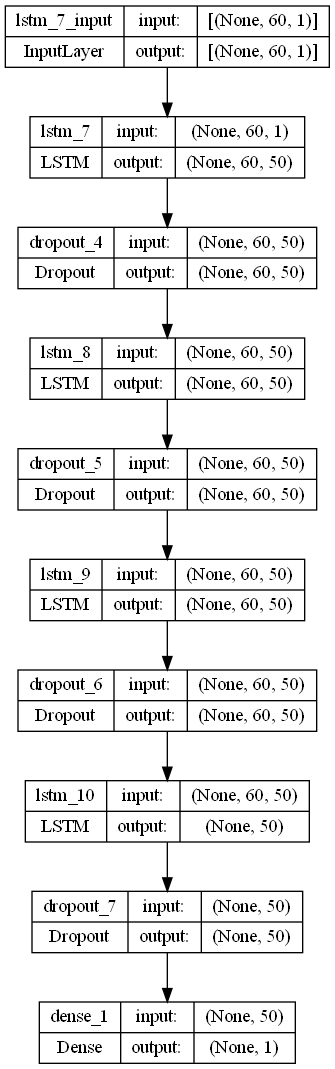

In [40]:
tf.keras.utils.plot_model(regressor, show_shapes=True, show_layer_names=True)

<br></br>
***
## Prediction

In [35]:
testDataCSV = pd.read_csv('Google_Stock_Price_Test.csv')
testSet = testDataCSV.iloc[:, 1:2].values

combinedDataset = pd.concat((trainingDataCSV['Open'], testDataCSV['Open']), axis = 0)
inputs = combinedDataset[len(combinedDataset) - len(testDataCSV) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

xTest = []
for i in range(60, 80):
    xTest.append(inputs[i-60:i, 0])

xTest = np.array(xTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))
predictedStockPrice = regressor.predict(xTest)
predictedStockPrice = sc.inverse_transform(predictedStockPrice)

1/1 [==============================] - 1s 1s/step


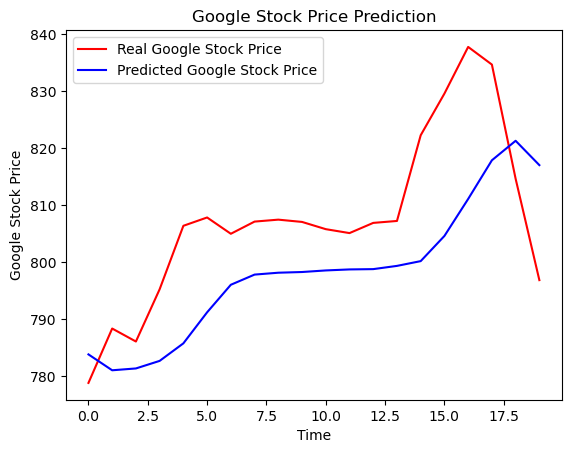

In [37]:
plt.plot(testSet, color = 'red', label = 'Real Google Stock Price')
plt.plot(predictedStockPrice, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()